In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
from tvb.simulator.lab import *

/home/izaak/local_repos/nostromo/tvb-root_WT_ionx/tvb_library/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [4]:
%%capture

import numpy as np
import time as tm
import matplotlib.pyplot as plt        
import matplotlib.gridspec as gridspec 
###############################################################################

from tvb.simulator.lab import *
import networkx as nx

In [5]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 100)
print(viridis)

/tmp/ipykernel_29239/2640453070.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', 100)


In [7]:
cln=[viridis(4),viridis(4),viridis(4),'tomato',viridis(4),viridis(4)]

In [28]:
####################################################################
# IMPORT STRUCTURAL CONNECTIVITY
####################################################################
SC6_con = connectivity.Connectivity.from_file(os.path.abspath("6x6full.zip"))

In [27]:
nregions = len(SC6_con.weights)   
condspeed=np.infty 
SC6_con.speed = np.array([condspeed])
np.fill_diagonal(SC6_con.weights, 0.)

#normalization
SC6_con.configure()

SC6 = SC6_con.weights
SC6_con.tract_lengths=SC6_con.tract_lengths
SC6_tracts = SC6_con.tract_lengths
SC6_labels = ['A','B','C','D','E','F']

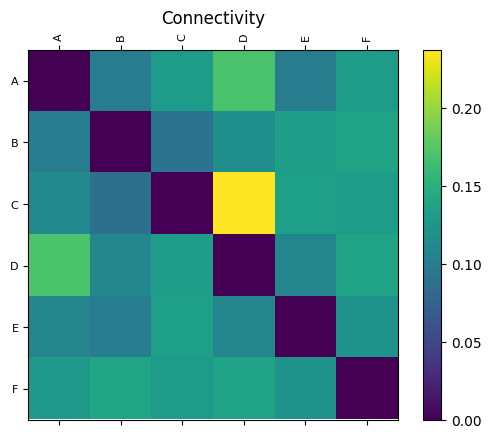

In [30]:
SC6_con.configure()

plot_connectivity(SC6_con,plot_tracts=False)

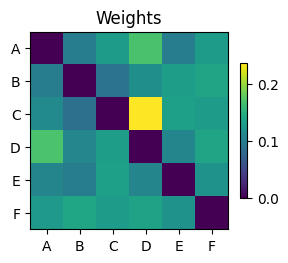

In [10]:
plt.figure(figsize=(3,3))
plt.imshow(SC6);plt.xticks(np.arange(6),SC6_labels);plt.yticks(np.arange(6),SC6_labels);plt.title('Weights');plt.colorbar(shrink=0.5)
plt.tight_layout()
plt.show()

In [11]:
viridis= cm.get_cmap('viridis', 10)

/tmp/ipykernel_29239/4062987830.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis= cm.get_cmap('viridis', 10)


In [12]:
cln=[viridis(4),viridis(4),viridis(4),'tomato',viridis(4),viridis(4)]

/tmp/ipykernel_29239/1828116002.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


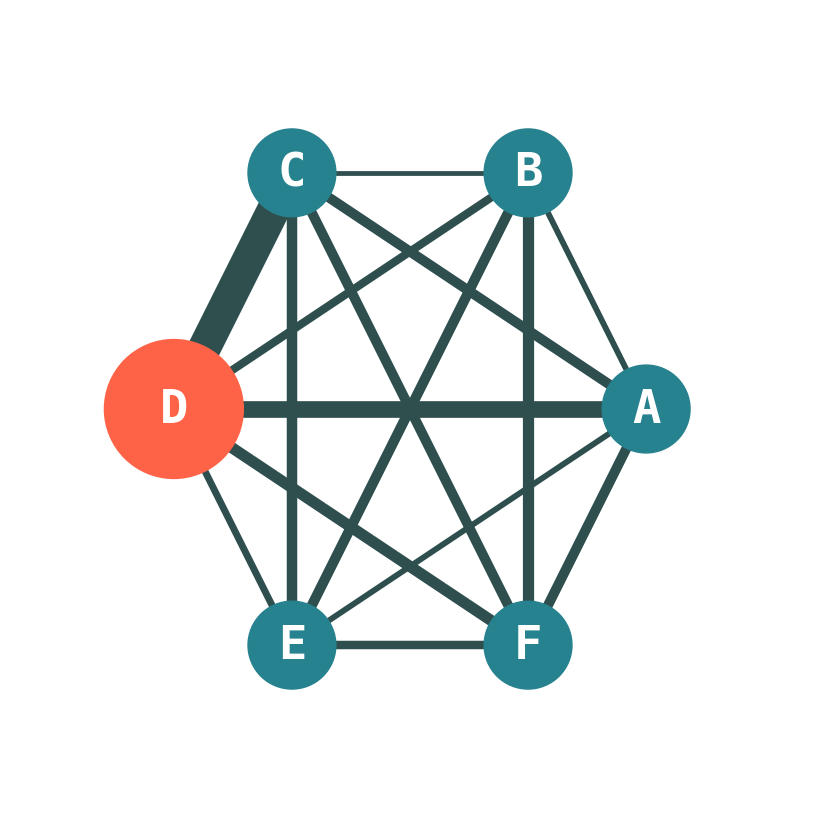

In [35]:
G=nx.from_numpy_array(SC6_tracts)
weights = 20.5*SC6[np.triu_indices(len(SC6),1)]
plt.figure(figsize=(8,8))
nx.draw_circular(G,labels=dict(enumerate(SC6_labels)),
                 width=weights**2, node_size=[4000,4000,4000,10000,4000,4000],font_color='w',edge_color='darkslategray',font_size=34,font_weight='bold',font_family='monospace',node_color=cln)
plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.4*x for x in axis.get_xlim()])
axis.set_ylim([1.4*y for y in axis.get_ylim()])
plt.tight_layout()
#path='/Users/giovanni/Documents/GitHub/fufo/data/Interim/Abhirup/Figures/Fig6/'
#plt.savefig(path+'Fig6_Net.pdf',dpi=300,transparent=True)
plt.show()

# CONFIGURE

In [14]:
E = 0
K_bath = 15.5
J=0.08
eta=0
Delta=1
R_minus=0.02
R_plus=-0.1
c_minus=-44.24
c_plus=-20.4
Vstar = -31

In [15]:
## Initialise Integrator
dt = .1
heunint = integrators.RungeKutta4thOrderDeterministic(dt=dt)
cut_in=0
simlen=20e3+cut_in
x_0=np.random.uniform(low=0.1, high=0.1, size=((1,1,nregions,1)))
V_0=np.random.uniform(low=-15., high=-15., size=((1,1,nregions,1)))
n_0=np.random.uniform(low=0.45, high=0.45, size=((1,1,nregions,1)))
DKi_0=np.random.uniform(low=-5, high=-5, size=((1,1,nregions,1)))
Kg_0=np.random.uniform(low=-16., high=-16., size=((1,1,nregions,1)))
init_cond=np.concatenate([x_0, V_0, n_0, DKi_0, Kg_0], axis=1)

# Healthy

In [16]:
G=0.
THH = models.HHIonExchange(
            E = np.r_[E],
            K_bath = np.r_[5.5,5.5,5.5,K_bath,5.5,5.5],
            J = np.r_[J],
            eta = np.r_[eta],
            Delta = np.r_[Delta],
            c_minus = np.r_[c_minus],
            R_minus = np.r_[R_minus],
            c_plus = np.r_[c_plus],
            R_plus = np.r_[R_plus],
            Vstar = np.r_[Vstar])

In [17]:
THH

In [18]:
# Initialise some Monitors with period in physical time.
#mon_tavg = monitors.TemporalAverage(period=Tperiod)
mon_raw = monitors.Raw()
what_to_watch = (mon_raw, ) #(mon_tavg, mon_bold) 

# Initialise Coupling
con_coupling = coupling.Scaling(a=np.array([G]))

# Initialise the Simulator.
sim = simulator.Simulator(model=THH,
                          connectivity=SC6_con,
                          conduction_speed=condspeed,
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors= what_to_watch,
                          simulation_length=simlen) 
sim.initial_conditions = init_cond    
sim.configure()

In [19]:
####################################################################
# RUN the SIMULATION 
####################################################################
(raw_time, raw_data),  = sim.run()

In [20]:
# Make the lists numpy.arrays for easier use.    
RAW_h=np.squeeze(np.array(raw_data))   

R_h=(1000*R_minus/np.pi)*RAW_h[:,0,:]
V_h=RAW_h[:,1,:]

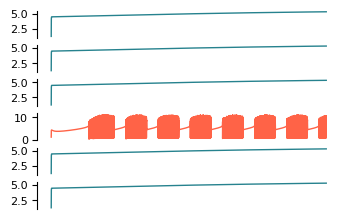

In [21]:
fig, ax = plt.subplots(nrows=6,ncols=1,figsize=(3.3,2.))
for i in range(6):
    ax[i].plot(R_h[:,i],c=cln[i],linewidth=1)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].set_xticks([])
    ax[i].tick_params(labelsize=8)
plt.tight_layout(pad=0)
plt.show()

# Pathological 

In [23]:
K_bath

15.5

In [24]:
G = 100.
THH = models.HHIonExchange(
            E = np.r_[E],
            K_bath = np.asarray([5.5,5.5,5.5,K_bath,5.5,5.5]),
            J = np.r_[J],
            eta = np.r_[eta],
            Delta = np.r_[Delta],
            c_minus = np.r_[c_minus],
            R_minus = np.r_[R_minus],
            c_plus = np.r_[c_plus],
            R_plus = np.r_[R_plus],
            Vstar = np.r_[Vstar])


# Initialise some Monitors with period in physical time.
mon_raw = monitors.Raw()
what_to_watch = (mon_raw, ) #(mon_tavg, mon_bold) 

# Initialise Coupling
con_coupling = coupling.Scaling(a=np.array([G]))

# Initialise the Simulator.
sim = simulator.Simulator(model=THH,
                          connectivity=SC6_con,
                          conduction_speed=condspeed,
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors= what_to_watch,
                          simulation_length=simlen) 
sim.initial_conditions = init_cond    
sim.configure()

In [25]:
####################################################################
# RUN the SIMULATION 
####################################################################
(raw_time, raw_data),  = sim.run()

In [26]:
# Make the lists numpy.arrays for easier use.    
#TAVG=np.squeeze(np.array(tavg_data))   
RAW_p=np.squeeze(np.array(raw_data))   

R_p=(1000*R_minus/np.pi)*RAW_p[:,0,:]
V_p=RAW_p[:,1,:]

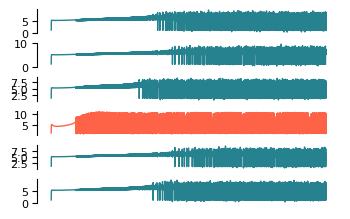

In [27]:
fig, ax = plt.subplots(nrows=6,ncols=1,figsize=(3.3,2.))
for i in range(6):
    ax[i].plot(R_p[:,i],c=cln[i],linewidth=1)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].set_xticks([])
    ax[i].tick_params(labelsize=8)

plt.tight_layout(pad=0)
plt.show()